### Audio Authenticity

#### References

+ Colab Notebook: [spectragram_analysis](https://colab.research.google.com/github/NeuromatchAcademy/course-content-dl/blob/main/projects/ComputerVision/spectrogram_analysis.ipynb)

### Sample Data 

The spoofed sample is `sound_s.wav`

+ The two WAV files are encoded at separate sampling rates.
+ `Sound B` is encoded in mono at `16,000 Hz` which is particularly low. The Nyquist frequency is half the sample rate.

\begin{align}
  f_N = \frac{f_S}{2}
\end{align}

+ When a sound is discretized into WAV, each value is an integer sample representing the amplitude. The fourier transform cannot extract frequencies approaching and exceeding $f_N$.

+ `Sound S` is encoded at `48,000 Hz`. This file's spectral domain has a sharp dropoff at frequencies above it's $f_N$. Since the recording is at a higher sample rate, its STFT can return values at higher frequencies. These can be seen above `8 kHz` as a noise signature of less than `-60dB`.

+ However, in the spectrogram for =Sound S=, there is no clear signal above `8,000 Hz`. If the cutoff was gradual, this could indicate frequency limitations in the microphones, like in the lower end of the spectrogram for `Sound B`. The cutoff is sharp, which indicates a reencoded recording without interpolation.




In [209]:
# @title Install Dependencies

!sudo apt-get install -y ffmpeg --quiet
!pip install librosa --quiet
!pip install imageio --quiet
!pip install imageio-ffmpeg --quiet
!pip install wavinfo --quiet

Reading package lists...
Building dependency tree...
Reading state information...
ffmpeg is already the newest version (7:4.2.7-0ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.


In [210]:
# @title Import necessary libraries.

import os
import glob
import imageio
import random, shutil
import torch
import torch.nn as nn
from tqdm.notebook import tqdm
#import torch.nn.functional as F
#import torchvision.datasets as datasets
#import torchvision.transforms as transforms
import numpy as np
import IPython.display as display
import librosa
import librosa.display


In [211]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
from functools import reduce
from typing import Any, cast, Tuple

# hmmmm ... okay
#from typing import Self #, LiteralString, Never, NoReturn, Self, TypeAlias

# typing invocations from librosa
# from numpy.typing import DTypeLike
# from typing import Any, Callable, Optional, Tuple, List, Union, overload
# from typing_extensions import Literal
# from .._typing import _WindowSpec, _PadMode, _PadModeSTFT

from pprint import pp
from wavinfo import WavInfoReader

In [212]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [213]:
from pathlib import Path

wavfiles_path='/content/drive/MyDrive/upwork/spoofed-sounds'
p = Path(wavfiles_path)

wavfiles = list(p.glob('*.wav'))

In [ ]:
display.Audio(wavfiles[0])

In [ ]:
display.Audio(wavfiles[1])

### Sound 0

In [290]:
def audio_stats(y, sample_rate):
  to_join = []
  to_join.append(f'Y: {np.shape(y)[0]}')

  to_join.append(f'Sample rate: {sample_rate/1000.0} kHz')
  to_join.append(f'Length: {np.shape(y)[0]/sample_rate}s')

  return " ".join(to_join)

#def plotsound(sample_path):


In [ ]:
# wir(wavfiles[0]),wir(wavfiles[1])

# pp(s0.data.frame_count)
# pp([s0.fmt, s1.fmt])


144000
[WavAudioFormat(audio_format=1, channel_count=1, sample_rate=16000, byte_rate=32000, block_align=2, bits_per_sample=16),
 WavAudioFormat(audio_format=1, channel_count=2, sample_rate=48000, byte_rate=192000, block_align=4, bits_per_sample=16)]




### WavInfoReader

#### Parsing

+ first calls `parse_chunk` from `.riff_parser` to get a list of chunks. these are descriptors that act as location markers for different chunks.
+ calls `seek(0)` to set the state of the file reader
+ then runs through calls to describe the metadata 
+ finally calls `self._describe_data()` to get data about WAV data

#### data descriptor calculations

```python
WavInfoReader first parses chunks
return WavDataDescriptor(
  byte_count=data_chunk.length,
  frame_count=int(data_chunk.length / self.fmt.block_align))
```



In [215]:
from dataclasses import dataclass, field

#@dataclass(init=True, repr=True, eq=True, order=False, unsafe_hash=False, frozen=False,
#           match_args=True, kw_only=False, slots=False, weakref_slot=False)

stftparam = {
    'n_fft': 2048,      # defaults to 2048
    'win_length': 2048, # defaults to n_fft
    'hop_length': 512   # defaults to (n_fft/4)
}

specparam = {
    'x_axis': 'time',
    'y_axis': 'log'
}

# to type or not to tyyyyype ... that is the question
#self.name = cast(str, (self.p and self.p.name))

# STFT output is complex-valued (use np.abs(...))
# the mel_spectrogram handles this
# def stft(y: np.ndarray, *, n_fft: int=2048, hop_length: Optional[int]=None, 
#   win_length: Optional[int]=None, window: _WindowSpec='hann', 
#   center: bool=True, dtype: Optional[DTypeLike]=None, 
#   pad_mode: _PadModeSTFT='constant', 
#   out: Optional[np.ndarray]=None) -> np.ndarray

# convert between indices of time/fft domain
# librosa.frames_to_samples()
# librosa.samples_to_frames()

@dataclass
class Wav:
  p: os.PathLike[Any]
  name: str = field(init = False)
  metadata: WavInfoReader = field(init = False)
  samples: Tuple[np.ndarray, float] = field(init = False)
  stft: np.ndarray = field(init = False)
  length: float = field(init = False)
  
  def __post_init__(self):
    self.name = self.p.name
    self.metadata = WavInfoReader(self.p)
    self.samples = librosa.load(self.p, sr=self.sr())
    # TODO: perhaps split this into phases, stft data is more useful in pandas
    self.length = len(self.samples[0]) / self.sr()
    # self.stft = np.abs(librosa.stft(self.samples[0], self. ))

  # WAV Metadata (content)
  def bc(self): # byte_count
    return self.metadata.data.byte_count 
  
  def frame_count(self):
    return self.metadata.data.frame_count

  # WAV Metadata (format)
  def af(self): # audio_format
    return self.metadata.fmt.audio_format

  def sr(self): # sample_rate
    return self.metadata.fmt.sample_rate
  
  def cc(self): # channel_count
    return self.metadata.fmt.channel_count
  
  def br(self): # byte_rate
    return self.metadata.fmt.byte_rate
  
  def ba(self): # block_align
    return self.metadata.fmt.block_align

  def bps(self): # block_align
    return self.metadata.fmt.bits_per_sample

  def __repr__(self):
    return f"Wav(name={self.name} length={self.length} sr={self.sr()} )"


In [216]:

s = list(map(Wav, wavfiles))
[s[0], s[1]]
[s[0].metadata.fmt, s[1].metadata.fmt]

[WavAudioFormat(audio_format=1, channel_count=1, sample_rate=16000, byte_rate=32000, block_align=2, bits_per_sample=16),
 WavAudioFormat(audio_format=1, channel_count=2, sample_rate=48000, byte_rate=192000, block_align=4, bits_per_sample=16)]

In [217]:
# total_bytes is s[n].metadata.data.byte_count
def total_bytes(sam):
  return sam.bps()*sam.sr()*sam.cc() / 8.0
 
[ total_bytes(s[0]), s[0].metadata.data , s[1].metadata.data ]

[32000.0,
 WavDataDescriptor(byte_count=288000, frame_count=144000),
 WavDataDescriptor(byte_count=1812480, frame_count=453120)]

#### Remaining Tasks

+ identify the max sample between both files and use for plotting
+ refactor plotting from the analysis


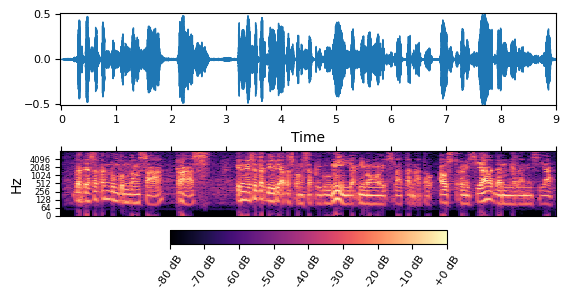

In [325]:
with wavfiles[0] as sample_path:

  sample_rate = 16000
  y, sr = librosa.load(sample_path, sr=sample_rate)
  sound_stats = audio_stats(y, sr)

  #fig = plt.figure(figsize=(10,40))
  fig = plt.figure()
  gs = fig.add_gridspec(ncols=4,nrows=3)
  ax_top = fig.add_subplot(gs[0,:])

  ax_top.margins(0.0)
  librosa.display.waveshow(y=y, sr=sample_rate, ax=ax_top);
  # ax_top.set_title(f"{sample_path.name} :: {sound_stats}", fontsize=10)
  ax_top.tick_params('x', top=False, bottom=True, labeltop=False, labelbottom=True, labelsize=8)
  ax_top.tick_params('y', labelsize=8)
  
  ax_spect = fig.add_subplot(gs[1,:],sharex=ax_top)
  sp = ax_spect
  spect = np.abs(librosa.stft(y, **stftparam))
  spect_db = librosa.amplitude_to_db(spect, ref=np.max)
  quadmesh = librosa.display.specshow(spect_db, sr=sample_rate, **stftparam, **specparam, ax=ax_spect)
  # ax_spect.set_box_aspect(0.125) # this is not da wei
  ax_spect.tick_params('y', labelsize=6)
  ax_spect.tick_params('x', top=True, bottom=False, labeltop=False, labelbottom=False, labelsize=8)
  ax_spect.set_xlabel('')
  cb = fig.colorbar(quadmesh, ax=ax_spect, location="bottom", format="%+2.f dB", shrink=0.6)
  cb.ax.tick_params(labelsize=8, rotation=55)

  gs.update(wspace=0.2,hspace=0.5)

leftmax: -0.02778775244951248 dB
rightmax: -0.03409350663423538 dB


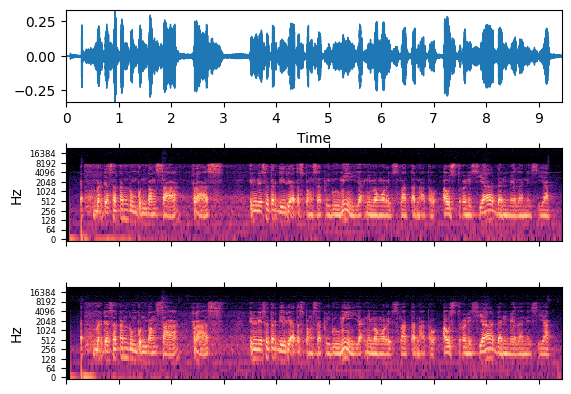

In [326]:

def amp2db(amp, ref):
  20*log10(amp/ref)

with wavfiles[1] as sample_path:

  sample_rate = 48000
  y, sr = librosa.load(sample_path, sr=sample_rate, mono=False)

  #maxamplitude = np.max(y, axis=1)
  #maxdb = np.max(librosa.amplitude_to_db(maxamplitude))
  maxlr = np.max(librosa.amplitude_to_db(y))

  left, right = y[0], y[1]
  leftmax, rightmax = np.max(left), np.max(right)
  print(f"leftmax: {leftmax/maxlr} dB")
  print(f"rightmax: {rightmax/maxlr} dB")

  sound_stats = audio_stats(left, sample_rate)

  #fig = plt.figure(figsize=(10,40))
  fig = plt.figure()
  gs = fig.add_gridspec(ncols=4,nrows=3)
  ax_top = fig.add_subplot(gs[0,:])

  ax_top.margins(0.0)
  librosa.display.waveshow(y=left, sr=sample_rate, ax=ax_top);
  # ax_top.set_title(f"{sample_path.name} :: {sound_stats}", fontsize=12)
  
  ax_spect = fig.add_subplot(gs[1,:], sharex=ax_top)
  spect = np.abs(librosa.stft(left, **stftparam))
  spect_db = librosa.amplitude_to_db(spect, ref=maxlr)
  #S_DB = librosa.amplitude_to_db(S, ref=np.max)
  quadmesh = librosa.display.specshow(spect_db, sr=sample_rate, **stftparam, **specparam, ax=ax_spect)
  ax_spect.tick_params('y', labelsize=6)
  ax_spect.tick_params('x', top=True, bottom=True, labeltop=False, labelbottom=False, labelsize=8)
  ax_spect.set_xlabel('')
  #cb = fig.colorbar(quadmesh, ax=ax_spect, location="top", format="%+2.f dB", shrink=1.2)
  #cb.ax.tick_params(labelsize=8, rotation=20)

  ax_spect = fig.add_subplot(gs[2,:])
  spect = np.abs(librosa.stft(right, **stftparam))
  spect_db = librosa.amplitude_to_db(spect, ref=maxlr)
  #S_DB = librosa.amplitude_to_db(S, ref=np.max)
  librosa.display.specshow(spect_db, sr=sample_rate, **stftparam, **specparam, ax=ax_spect)
  quadmesh = librosa.display.specshow(spect_db, sr=sample_rate, **stftparam, **specparam, ax=ax_spect)
  ax_spect.tick_params('y', labelsize=6)
  ax_spect.tick_params('x', top=True, bottom=True, labeltop=False, labelbottom=False, labelsize=8)
  ax_spect.set_xlabel('')
  
  gs.update(wspace=0.2,hspace=0.5)

'sound_s.wav'


### Other Methods of Analysis

#### Visual Analysis

- compare the spectrograms visually. The second sample obviously has noise artifacts in the low/high frequency region. 
- These are missing in the first sample. high/low frequencies are difficult to record/play on cell phone speakers
- however, FFT calculations using the wrong parameters could introduce what appears to be noise

#### PSD Method of analysis to determine authenticity:

- run the stft() on both samples with correct params
- extract noise (by filtering out signal with [spectral substraction](https://qr.ae/pyhDqI))
- retain the extracted noise data and compare its power-spectral densities of each audio clips

#### Stereo method

- there should be some way to analyze the directionality of the audio source in the second clip. however, there is no similar data from the first clip.

#### Onset method

- [calculate onsets](https://librosa.org/doc/latest/auto_examples/plot_superflux.html#sphx-glr-auto-examples-plot-superflux-py) for each audio sample
- attempt to align the onsets, though the onset-detection should occur early for the noisy sample. deciding on a fair alignment requires some linear(?) regression to produce a shared set of offsets for both files. the regression will eliminate the time-differences (clip #2 is 0.44s longer)
- from here, you have points of interest across both clips around. From these, you can produce an analysis with greater confidence.

Problem for analyzing these:

- the `stft()` function needs a `win_length` parameter.